In [1]:
import torch
from torch.utils.data.dataloader import DataLoader
import accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

import deep_reorder

In [2]:
DEFAULT_MODEL = "Qwen/Qwen2.5-0.5B"
DEFAULT_DATASET = "oivlisnet/c4-en"

In [3]:
import safetensors

tensors = {}
with safetensors.safe_open("../runs/deepreorderexperiment/checkpoints/step_2500/model.safetensors", framework="pt") as f:
    for k in f.keys():
        tensors[k] = f.get_tensor(k)

In [4]:
import re

original_positions_pattern = re.compile(r"layers\.(\d+)\.original_positions$")
linear_positions_pattern = re.compile(r"layers\.(\d+)\.linear_positions$")
correlation_matrix_pattern = re.compile(r"layers\.(\d+)\.correlation_matrix$")

In [5]:
original_positions_dict = {}
linear_positions_dict = {}
correlation_matrix_dict = {}

In [6]:
for key in tensors.keys():
    original_match = original_positions_pattern.search(key)
    if original_match:
        layer_num = int(original_match.group(1))
        original_positions_dict[layer_num] = tensors[key]
    linear_positions_match = linear_positions_pattern.search(key)
    if linear_positions_match:
        layer_num = int(linear_positions_match.group(1))
        linear_positions_dict[layer_num] = tensors[key]
    correlation_matrix_match = correlation_matrix_pattern.search(key)
    if correlation_matrix_match:
        layer_num = int(correlation_matrix_match.group(1))
        correlation_matrix_dict[layer_num] = tensors[key]

In [7]:
accelerator = accelerate.Accelerator()
device = accelerator.device

model = AutoModelForCausalLM.from_pretrained(DEFAULT_MODEL, torch_dtype="bfloat16", device_map="auto")
model = torch.compile(model, backend="eager")
model.to(device)

tokenizer = AutoTokenizer.from_pretrained(DEFAULT_MODEL)

model = accelerator.prepare(model)

In [8]:
def plot_activation_heatmap(prompt, model, tokenizer):
    """Create activation heatmap for a given input."""
    tokens = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        padding_side="left",
        truncation=True,
        max_length=AutoConfig.from_pretrained(DEFAULT_MODEL).max_position_embeddings,
    )
    tokens.to(device)

    from collections import defaultdict

    activations = {i: [] for i in range(24)}
    hooks = []

    def generate_hook(module_idx):
        def hook_fn(module, input_tensor, output_tensor):
            activations[module_idx].append(output_tensor[0].detach().cpu())

        return hook_fn

    for idx, layer in enumerate(model.model.layers):
        hook = layer.register_forward_hook(generate_hook(idx))
        hooks.append(hook)

    with torch.no_grad():
        output_tokens = model.generate(
            tokens.input_ids,
            attention_mask=tokens.attention_mask,
            do_sample=False,
            max_new_tokens=200,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )
        generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)

    for hook in hooks:
        hook.remove()

    for i in range(len(activations)):
        activations[i] = torch.cat(activations[i], dim=1).squeeze(0).mean(dim=0)

    before_act = torch.stack([activation for idx, activation in activations.items()]).transpose(0, 1).float()
    after_act = torch.stack([activation[linear_positions_dict[idx].argsort()] for idx, activation in activations.items()]).transpose(0, 1).float()

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    sns.heatmap(before_act, ax=axes[0], cbar=False)
    sns.heatmap(after_act, ax=axes[1], cbar=False)

    axes[0].set_title("Before sorting.")
    axes[1].set_title("After sorting.")

    fig.suptitle(f"Prompt: {prompt}", fontsize=14)
    return fig, before_act, after_act, generated_text

Tom Brady led the NFL in passing yards in the 2015 season, and he has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long time. He has been a leader in the NFL for a long


/var/folders/gx/_9gsljjx1tz3j34klp2k9vzc0000gn/T/ipykernel_25763/2242960341.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


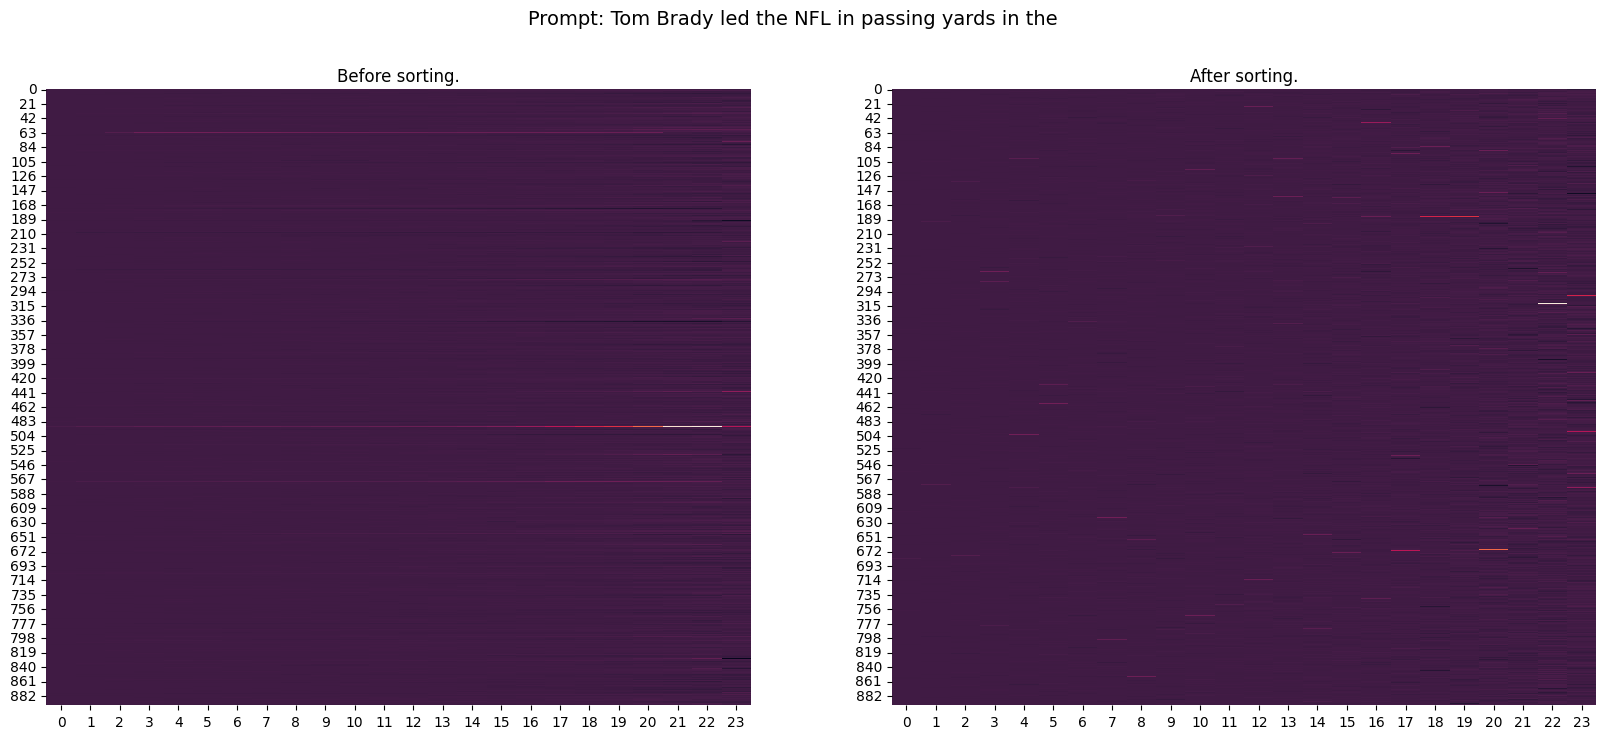

In [9]:
figure, before_activations, after_activations, response = plot_activation_heatmap(
    prompt="Tom Brady led the NFL in passing yards in the ",
    model=model,
    tokenizer=tokenizer,
);
print(response)
figure.show()

Between the years 2008 and 2010, Lionel Messi played for   Barcelona, Real Madrid, and Atletico Madrid. Messi was born in Argentina on 11 July 1987. He is the son of Argentine footballer Diego Messi. Messi is the youngest player in the history of the Argentine football league. He is the 10th player in the history of the Argentine football league to play for more than one club. Messi has won 11 world cups, 11 La Liga titles, 11 Copa del Rey titles, 11 La Liga Cups, 11 Champions League titles, 11 Copa del Rey titles, 11 La Liga Cups, 11 Copa del Rey titles, 11 La Liga Cups, 11 Copa del Rey titles, 11 La Liga Cups, 11 Copa del Rey titles, 11 La Liga Cups, 11 Copa del Rey titles, 11 La Liga Cups, 11 Copa del Rey titles, 11


/var/folders/gx/_9gsljjx1tz3j34klp2k9vzc0000gn/T/ipykernel_25763/3843793502.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


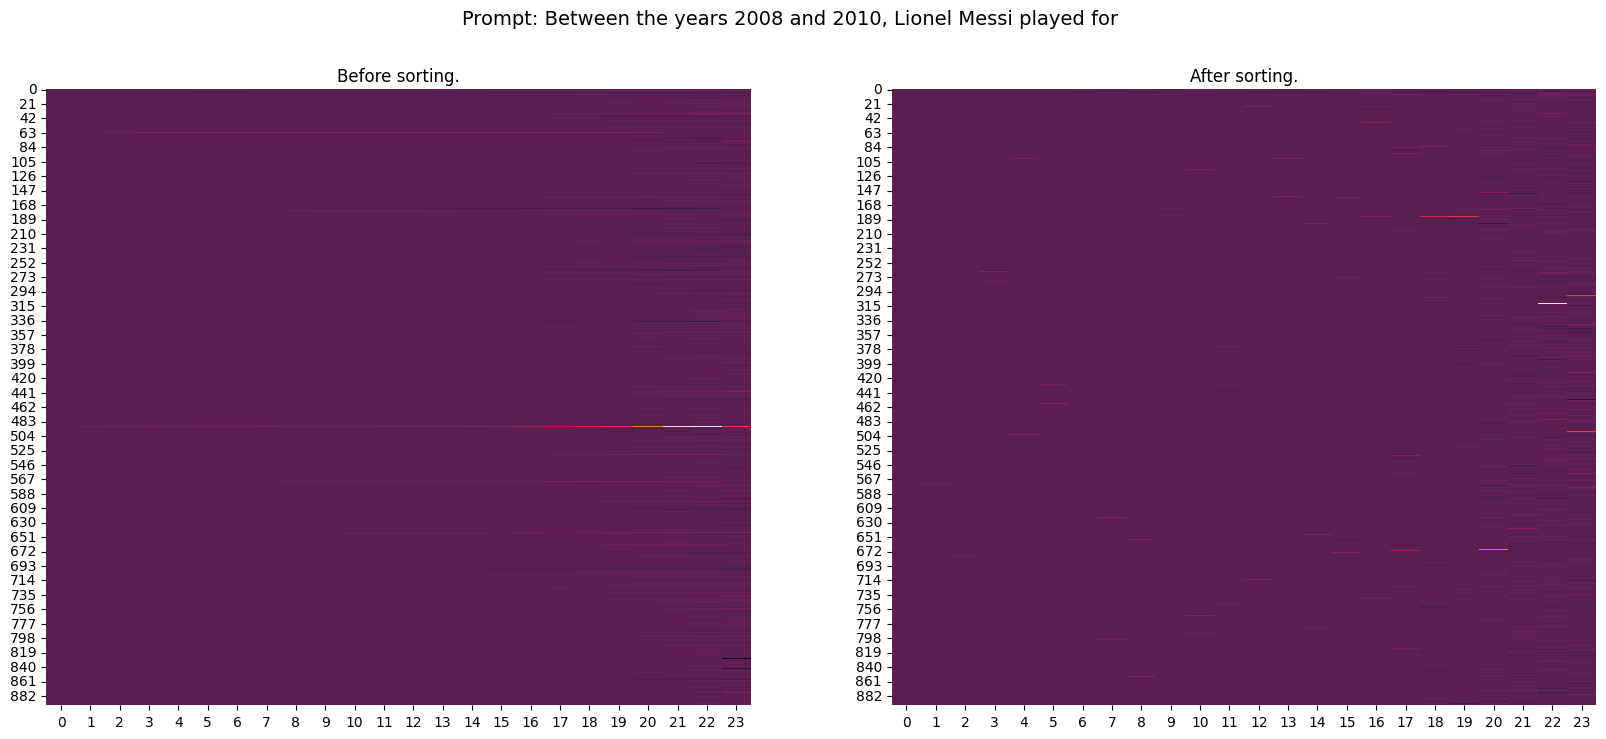

In [10]:
figure, before_activations, after_activations, response = plot_activation_heatmap(
    prompt="Between the years 2008 and 2010, Lionel Messi played for  ",
    model=model,
    tokenizer=tokenizer,
);
print(response)
figure.show()

Tom Brady and Lionel Messi are prominent 2018 NBA players. Both are known for their exceptional skills and are considered to be the best players in the league. However, they have different playing styles and approaches to the game. Brady is known for his physicality and ability to make plays from the field, while Messi is known for his ability to shoot long-range shots and his ability to create scoring opportunities for his team. Both players have made significant contributions to their respective teams and have won numerous championships.


/var/folders/gx/_9gsljjx1tz3j34klp2k9vzc0000gn/T/ipykernel_25763/1029337764.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


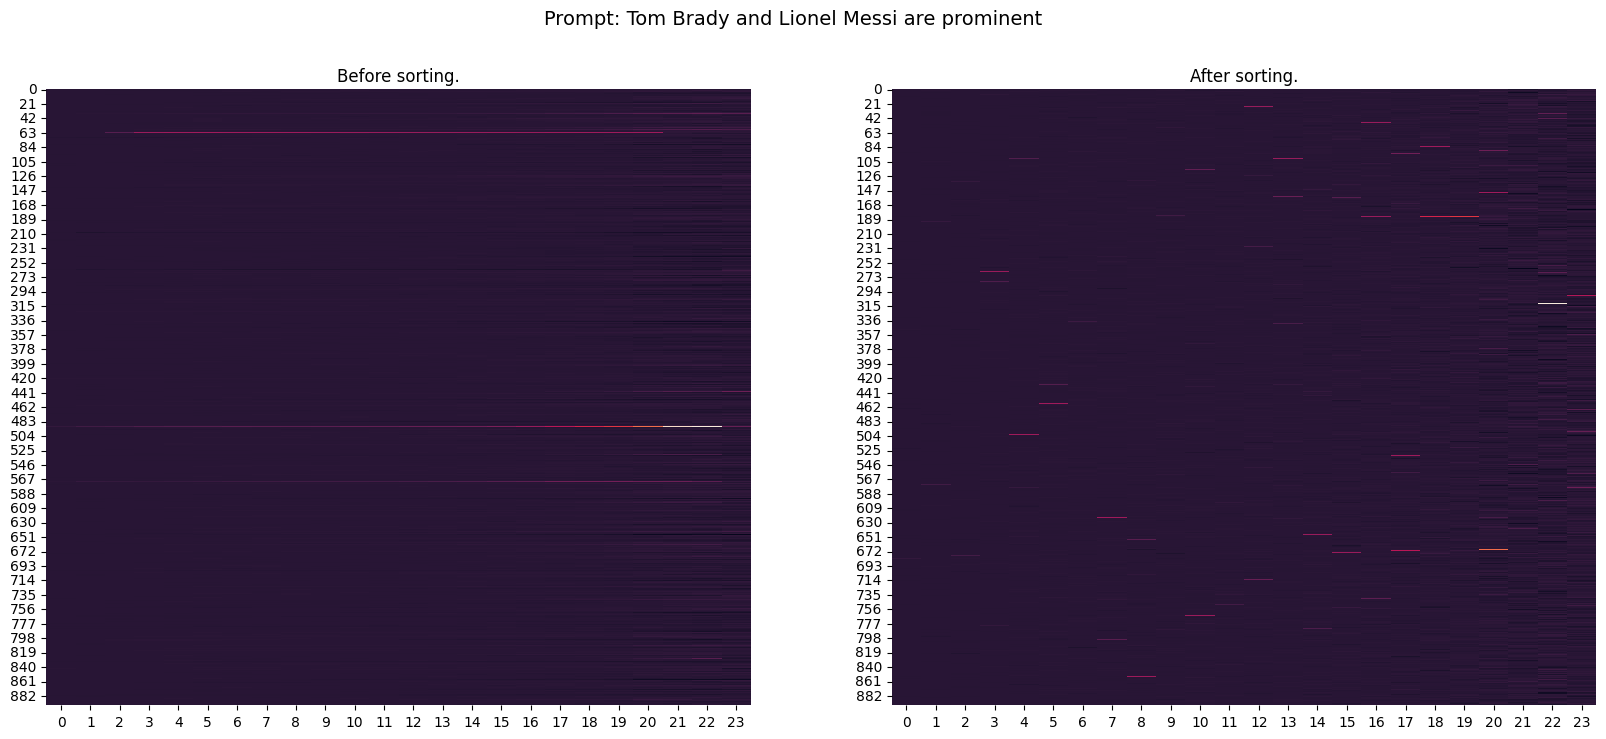

In [11]:
figure, before_activations, after_activations, response = plot_activation_heatmap(
    prompt="Tom Brady and Lionel Messi are prominent ",
    model=model,
    tokenizer=tokenizer,
);
print(response)
figure.show()

When you combine the colors red and blue, you get 16 different colors. If you combine the colors red and green, you get 16 different colors. If you combine the colors red and yellow, you get 16 different colors. If you combine the colors blue and green, you get 16 different colors. If you combine the colors blue and yellow, you get 16 different colors. If you combine the colors red and yellow, you get 16 different colors. If you combine the colors red and blue, you get 16 different colors. If you combine the colors red and green, you get 16 different colors. If you combine the colors blue and green, you get 16 different colors. If you combine the colors blue and yellow, you get 16 different colors. If you combine the colors red and yellow, you get 16 different colors. If you combine the colors red and blue, you get 16 different colors. If you combine the colors red and green


/var/folders/gx/_9gsljjx1tz3j34klp2k9vzc0000gn/T/ipykernel_25763/4130309385.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


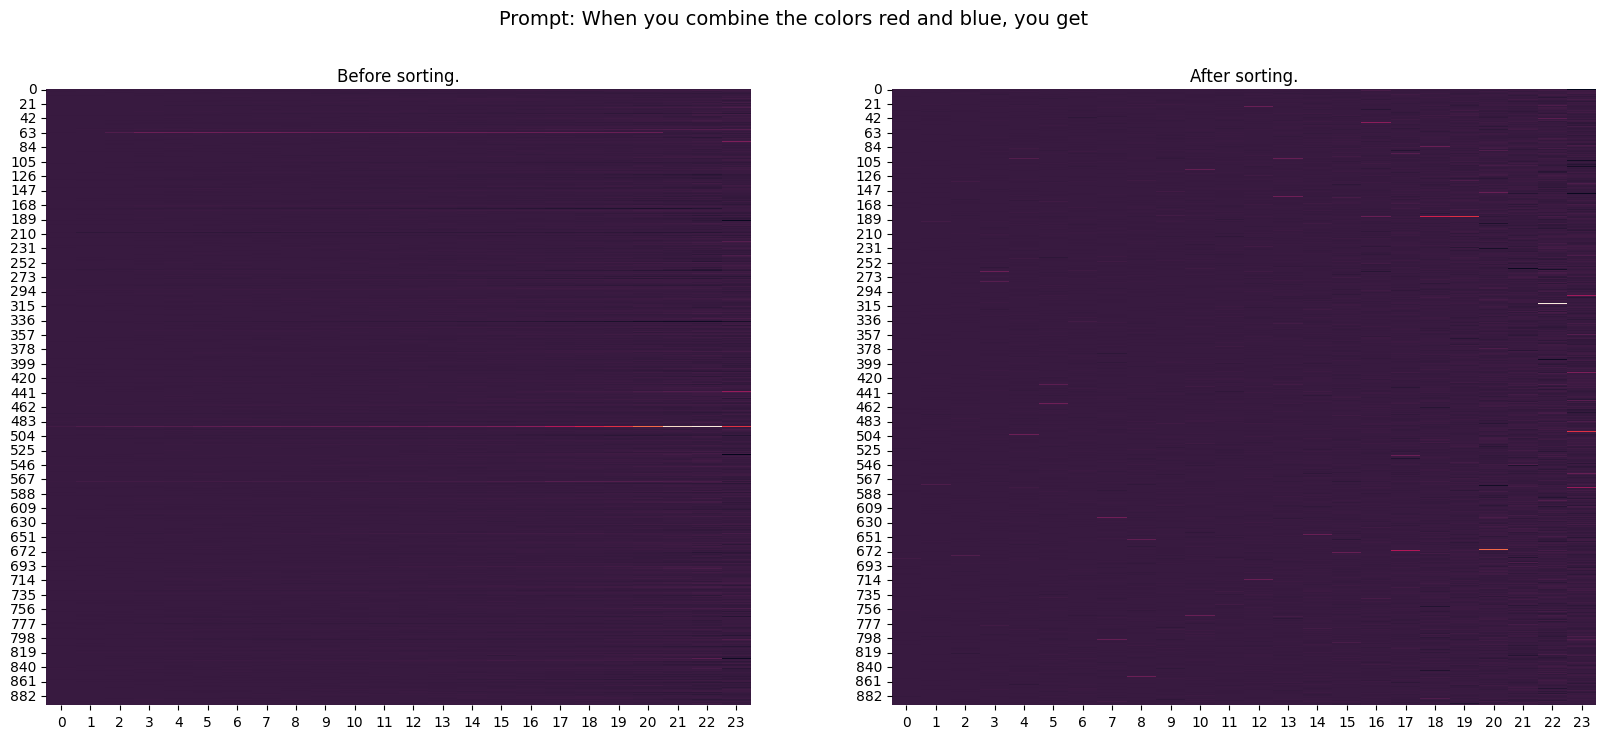

In [12]:
figure, before_activations, after_activations, response = plot_activation_heatmap(
    prompt="When you combine the colors red and blue, you get ",
    model=model,
    tokenizer=tokenizer,
);
print(response)
figure.show()